## Configuration and Intercomparison of Deep Learning Neural Models for Statistical Downscaling *(ilustrative case study)*
### *Geoscientific Model Development preprint*
### J. Baño-Medina, R. Manzanas and J. M. Gutiérrez
https://doi.org/10.5194/gmd-2019-278

GitHub repository at https://github.com/SantanderMetGroup/DeepDownscaling

This notebook is part of the companion material to the manuscript entitled *Configuration and Intercomparison of Deep Learning Neural Models for Statistical Downscaling* by *J. Baño-Medina, R. Manzanas and J. M. Gutiérrez*, in *Geoscientific Model Development* (https://doi.org/10.5194/gmd-2019-278). In order to increase research transparency, this document allows to reproduce the results presented in the mentioned paper for one of the analysis undertaken there, the prediction of temperature with a convolutional neural network (CNN hereafter) with 10 feature maps. Note however that the full code needed to reproduce the rest of experiments presented in the paper (including all architectures, standard bencmarking methods and also resutls for precipitation) can be found in the above GitHub repository. 

**Note:** This notebook is written in the free programming language `R` and builds on the `R` framework [`climate4R`](https://github.com/SantanderMetGroup/climate4R) (C4R hereafter, conda and docker installations available), a suite of `R` packages developed by the [Santander Met Group](http://meteo.unican.es) for transparent climate data access, post processing (including bias correction and downscaling, via the [`downscaleR`](https://github.com/SantanderMetGroup/downscaleR) package; [Bedia et al. 2020](https://www.geosci-model-dev-discuss.net/gmd-2019-224/)) and visualization. The interested reader is referred to [Iturbide et al. 2019](https://www.sciencedirect.com/science/article/pii/S1364815218303049?via%3Dihub). 

Here we use a **specific version of the conda C4R installer (v1.3.0)** containing the package versions needed to fully reproduce the results of this notebook and including also the [`downscaleR.keras`](https://github.com/SantanderMetGroup/downscaleR.keras) package which is not included in the standard C4R conda distribution (visit this [site](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) for more information on how to obtain conda). Thus, below we illustrate how to create a new environment with conda to install the C4R libraries (please visit the [`climate4R`](https://github.com/SantanderMetGroup/climate4R) github repository for more details regarding the installation procedures). Note that the packages can be also installed individually, but this is more time consuming than using the conda installation.

In [ ]:
## --- type this in terminal to proceed with the installation of C4R with conda

# conda create --name myEnvironment  # create a new environment
# conda activate myEnvironment  # activate the environment
## install climate4R from conda v1.3.0 version (includes deep learning tools)
# conda install -c conda-forge -c defaults -c santandermetgroup climate4r=1.3.0  
# R # type 'R' to initialize R software

## Loading and preparing the data
As explained in the paper, we have considered 20 large-scale variables from the ERA-Interim reanalysis as predictors and surface temperature from E-OBS as predictand. All these data can be loaded remotely from the [Santander Climate Data Service](http://meteo.unican.es/cds) (register [here](https://meteo.unican.es/trac/wiki/udg) freely to get a user), which provides access to various kinds of climate datasets (global and regional climate models, reanalysis, observations...). We will use the C4R packages [`loadeR`](https://github.com/SantanderMetGroup/loadeR) and [`transformeR`](https://github.com/SantanderMetGroup/transformeR) to load and postprocess the required information.

In [1]:
library(loadeR)      # version 1.6.1 (from conda installation)      
library(transformeR) # version 1.7.4 (from conda installation) 
library(magrittr)    # auxiliary package to simplify the code syntax
loginUDG(username = "", password = "")  # login in the Santander CDS

Loading required package: rJava
Loading required package: loadeR.java
Java version 1.8x amd64 by JetBrains s.r.o detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
Loading required package: climate4R.UDG
climate4R.UDG version 0.1.0 (2020-02-24) is loaded
Please use 'citation("climate4R.UDG")' to cite this package.
loadeR version 1.6.1 (2020-03-23) is loaded
Please use 'citation("loadeR")' to cite this package.

Attaching package: ‘loadeR’

The following object is masked from ‘package:climate4R.UDG’:

    loginUDG




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 1.7.4 (2020-03-23) is loaded
Please see 'citation("transformeR")' to cite this package.
Warning message:
“'loginUDG' is deprecated and will eventually be removed from loadeR.
Use 'loginUDG' from package climate4R.UDG instead.”[2020-03-26 11:04:47] Setting credentials...
[2020-03-26 11:04:47] Success!
Go to <http://www.meteo.unican.es/udg-tap/home> for details on your authorized groups and datasets


### Loading predictors

In [2]:
## --- the next chunk of code takes about 5 minutes to be completed 
## --- in a personal computer with the technical specifications given at the end of this notebook

## loading predictor variables from ERA-Interim
variables <- c("z@500","z@700","z@850","z@1000",  
               "hus@500","hus@700","hus@850","hus@1000",
               "ta@500","ta@700","ta@850","ta@1000",
               "ua@500","ua@700","ua@850","ua@1000",
               "va@500","va@700","va@850","va@1000")
x <- lapply(variables, function(x) {
  loadGridData(dataset = "ECMWF_ERA-Interim-ESD",
               var = x,
               lonLim = c(-10, 32), # longitude domain: 22 gridboxes (2º resolution)
               latLim = c(36, 72),  # latitude domain: 19 gridboxes (2º resolution)
               years = 1979:2008)  # total period of study
}) %>% makeMultiGrid() %>% redim(, drop = T)

NOTE: Accessing harmonized data from a public UDG dataset
[2020-03-26 11:04:56] Defining harmonization parameters for variable "z@500"
[2020-03-26 11:04:56] Opening dataset...
[2020-03-26 11:04:58] The dataset was successfuly opened
[2020-03-26 11:04:58] Defining geo-location parameters
[2020-03-26 11:04:58] Defining time selection parameters
[2020-03-26 11:04:59] Retrieving data subset ...
Warning message:
“'C4R.vocabulary' is deprecated and will eventually be removed from loadeR.
Use 'C4R.vocabulary' from package climate4R.UDG instead.”[2020-03-26 11:05:10] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2020-03-26 11:05:10] Defining harmonization parameters for variable "z@700"
[2020-03-26 11:05:11] Opening dataset...
[2020-03-26 11:05:11] The dataset was successfuly opened
[2020-03-26 11:05:11] Defining geo-location parameters
[2020-03-26 11:05:12] Defining time selection parameters
[2020-03-26 11:05:12] Retrieving data subset ...
Warning message:
“'C4R.vocabulary' 

[2020-03-26 11:08:20] Defining geo-location parameters
[2020-03-26 11:08:21] Defining time selection parameters
[2020-03-26 11:08:21] Retrieving data subset ...
Warning message:
“'C4R.vocabulary' is deprecated and will eventually be removed from loadeR.
Use 'C4R.vocabulary' from package climate4R.UDG instead.”[2020-03-26 11:08:34] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2020-03-26 11:08:34] Defining harmonization parameters for variable "ua@1000"
[2020-03-26 11:08:34] Opening dataset...
[2020-03-26 11:08:34] The dataset was successfuly opened
[2020-03-26 11:08:34] Defining geo-location parameters
[2020-03-26 11:08:35] Defining time selection parameters
[2020-03-26 11:08:35] Retrieving data subset ...
Warning message:
“'C4R.vocabulary' is deprecated and will eventually be removed from loadeR.
Use 'C4R.vocabulary' from package climate4R.UDG instead.”[2020-03-26 11:08:48] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2020-03-26 11:08:49] Defining 

### Loading predictand

In [3]:
## --- the next chunk of code takes about 1 minute to be completed 
## --- in a personal computer with the technical specifications given at the end of this notebook

# loading predictand (temperature), from E-OBS
y <- loadGridData(dataset = "E-OBS_v14_0.50regular",
                   var = "tas",
                   lonLim = c(-10, 32), # longitude domain: 85 gridboxes (0.5º resolution)
                   latLim = c(36, 72),  # latitude domain: 73 gridboxes (0.5º resolution)
                   years = 1979:2008)  # total period of study

NOTE: Accessing harmonized data from a public UDG dataset
[2020-03-26 11:11:18] Defining harmonization parameters for variable "tas"
[2020-03-26 11:11:18] Opening dataset...
[2020-03-26 11:11:19] The dataset was successfuly opened
[2020-03-26 11:11:19] Defining geo-location parameters
[2020-03-26 11:11:19] Defining time selection parameters
[2020-03-26 11:11:19] Retrieving data subset ...
Warning message:
“'C4R.vocabulary' is deprecated and will eventually be removed from loadeR.
Use 'C4R.vocabulary' from package climate4R.UDG instead.”[2020-03-26 11:12:07] Done


### Train/test partition
As in the paper, we split the entire period of study into *train* (1979-2002) and *test* (2003-2008). To do that, we use the `subsetGrid` function from `transformeR`.

In [4]:
## predictor and predictand data for the train period
xT <- subsetGrid(x, years = 1979:2002)
yT <- subsetGrid(y, years = 1979:2002)

## predictor and predictand data for the test period
xt <- subsetGrid(x ,years = 2003:2008)
yt <- subsetGrid(y ,years = 2003:2008)

rm(x, y)  # to save memory

### Data standardization
The predictors are then standardized at a gridbox level using the function `scaleGrid` (also from `transformeR`).

In [5]:
# test period: standardization is done with respect to the train period
xt <- scaleGrid(xt, xT, type = "standardize", spatial.frame = "gridbox") %>% redim(drop = TRUE) 
# train period
xT <- scaleGrid(xT, type = "standardize", spatial.frame = "gridbox") %>% redim(drop = TRUE)  

[2020-03-26 11:14:21] - Scaling ...
[2020-03-26 11:15:22] - Done
[2020-03-26 11:15:22] - Scaling ...
[2020-03-26 11:16:15] - Done


## Downscaling
Once the predictors and the predictand are loaded, we can start the downscaling process. We rely on the [`C4R`](https://github.com/SantanderMetGroup/climate4R) library [`downscaleR.keras`](https://github.com/SantanderMetGroup/downscaleR.keras) which builds on [`keras`](https://cran.r-project.org/web/packages/keras/index.html), a high-level neural networks API which supports arbitrary network architectures and is seamlessly integrated with [TensorFlow](https://www.tensorflow.org/) (note that keras and TensorFlow are the state of the art in deep learning tools).

In [6]:
library(downscaleR.keras)  # version 0.0.2 (relies on keras version 2.2.2 and tensorflow version 2.0.0)

Loading required package: keras
Loading required package: tensorflow


We call the functions `prepareData.keras` and `prepareNewData.keras` to adequate the shape of predictor and predictand datasets to the keras format. This includes reshaping and resizing according to the first and last connections, which can be convolutional ("conv") or fully connected ("dense"). Moreover, this function discards all the gridboxes over the sea in the E-OBS dataset, for which there are no data; and also those land points for which some missing data is present (`keras` does not support missing values).

In [7]:
xy.T <- prepareData.keras(xT,yT,
                          first.connection = "conv",
                          last.connection = "dense",
                          channels = "last")
xy.t <- prepareNewData.keras(xt,xy.T)

Warning message in prepareData.keras(xT, yT, first.connection = "conv", last.connection = "dense", :
“removing gridpoints containing NaNs of object: y”

### Network architecture
Next, we define the architecture of our network (labelled as CNN10 in the paper; see Table 2). This network includes a block of three convolutional layers with 50, 25 and 10 (3 x 3 x number of inputs coming from the previous layer) kernels, respectively. In the hidden layers, the *ReLu* activation function is used, and padding is considered.

In [8]:
## defining the network architecture in keras
inputs <- layer_input(shape = dim(xy.T$x.global)[-1])
x = inputs # inputs
l1 = layer_conv_2d(x ,filters = 50, kernel_size = c(3,3), activation = 'relu', padding = "valid")# first layer
l2 = layer_conv_2d(l1,filters = 25, kernel_size = c(3,3), activation = 'relu', padding = "valid")# second layer
l3 = layer_conv_2d(l2,filters = 10, kernel_size = c(3,3), activation = 'relu', padding = "valid")# third layer
l4 = layer_flatten(l3)
outputs = layer_dense(l4,units = dim(xy.T$y$Data)[2]) # outputs
model <- keras_model(inputs = inputs, outputs = outputs) # network architecture

### Training the network
We are now in the position to compile and train the network. To do so, we use the function `downscaleTrain.keras` of `downscaleR.keras`. Note that, in terms of computation, this is the most expensive step (it took 3 hours in the machine used to write this notebook). 
Despite the parameter `epochs` is set to 10000 in the following chunk of code, early-stopping is applied with a patience of 30 epochs. Therefore, the training ends whenever the error in the validation dataset (10% of the training period, as indicated by `validation_split = 0.1`) stops decreasing.

In [ ]:
## --- the next chunk of code takes about 3 hours to be completed 
## --- in a personal computer with the technical specifications given at the end of this notebook

model <- downscaleTrain.keras(obj = xy.T,
                       model = model,
                       clear.session = FALSE,
                       compile.args = list("loss" = "mse",
                                           "optimizer" = optimizer_adam(lr = 0.0001)),
                       fit.args = list("batch_size" = 100,
                                       "epochs" = 1000,
                                       "validation_split" = 0.1,
                                       "verbose" = 1,
                                       "callbacks" = list(callback_early_stopping(patience = 30))))
## --- stopped at epoch 431, with loss: 0.8510, and val_loss: 1.0944

### Making predictions
Once the network has been successfully trained, we can use it to make our predictions. To do so we use the `downscalePredict.keras` function of `downscaleR.keras`. The previously defined `xy.t` object contains the new predictor data and we use the `model` to predict on this dataset. We use the argument `clear.session = TRUE` to remove the model and the `C4R.template` argument as a template where to locate the output neurons in the 2D latitude-longitude map.

In [10]:
## predict on the test set
pred <- downscalePredict.keras(newdata = xy.t,
                               model = model,
                               C4R.template = yT,
                               clear.session = TRUE)

Warning message in makeMultiGrid(.):
“One single grid was provided as input”NOTE: One single grid passed to the function: nothing to bind, so the original grid was returned


## Validation of results
Finally, the predictions which have been just created (and saved) are loaded and validated. Here we focus on the mean error obtained with respect to the observed cimatological value (bias) and the observed extreme percentiles 2th and 98th (biasP02 and biasP98). These metrics are computed using the function `valueMeasure` from the [`climate4R.value`](https://github.com/SantanderMetGroup/climate4R.value) package, a wrapper to the [`VALUE`](https://github.com/SantanderMetGroup/VALUE) package, which was developed in the [COST action VALUE](http://www.value-cost.eu/) for validation purposes. To plot the final maps (comparable to those shown in the bottom row of Figure 5 in the paper) we also need to load the [`visualizeR`](https://github.com/SantanderMetGroup/visualizeR) and `RColorBrewer` packages. If interested in knowing more about the plotting options used here, the reader is referred to the documentation of the `spatialPlot` function.

Loading required package: VALUE
---------------------------------------------- 
| VALUE version 2.2.0 (2019-12-09) is loaded |
|         http://www.value-cost.eu           |
----------------------------------------------
Get the latest stable version (2.2.1) using <devtools::install_github('SantanderMetGroup/VALUE')>
Warning message:
“no DISPLAY variable so Tk is not available”visualizeR version 1.5.1 (2020-01-05) is loaded
Please see 'citation("visualizeR")' to cite this package.
[2020-03-26 12:17:13] Computing member 1 out of 1
[2020-03-26 12:17:44] Done.
[2020-03-26 12:17:47] Computing member 1 out of 1
[2020-03-26 12:18:21] Done.
[2020-03-26 12:18:26] Computing member 1 out of 1
[2020-03-26 12:18:51] Done.
[2020-03-26 12:18:55] Computing member 1 out of 1
[2020-03-26 12:19:32] Done.
[2020-03-26 12:19:35] Computing member 1 out of 1
[2020-03-26 12:20:11] Done.
[2020-03-26 12:20:14] Computing member 1 out of 1
[2020-03-26 12:20:38] Done.
[2020-03-26 12:20:42] Computing member 1 out o

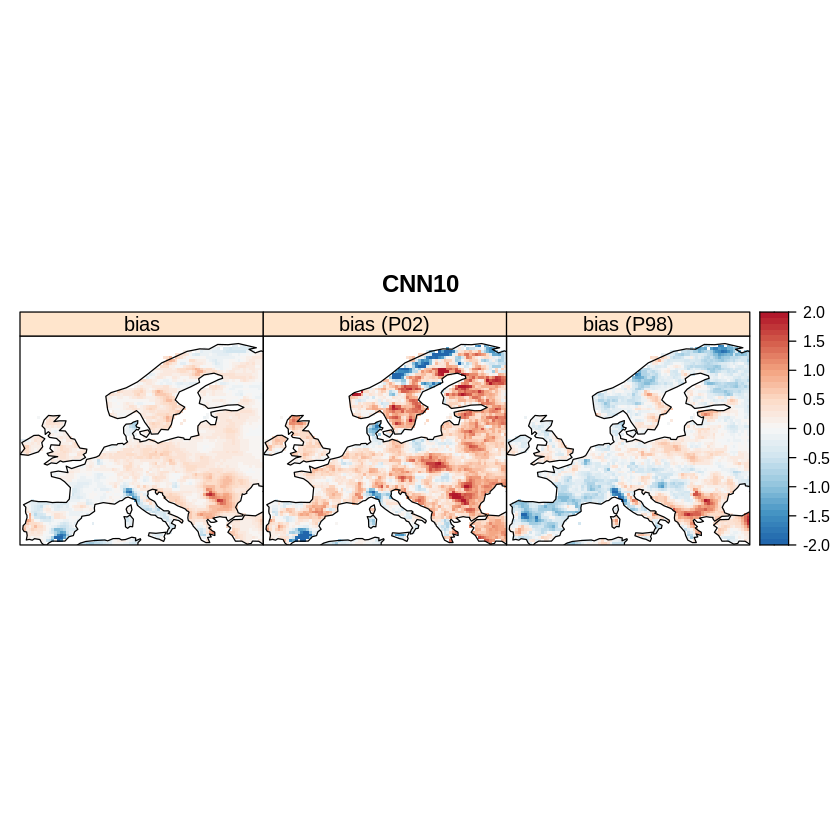

In [11]:
## --- the next chunk of code takes about 2 minutes be completed 
## --- in a personal computer with the technical specifications given at the end of this notebook

## loading packages
library(climate4R.value) # version 0.0.2 (also relies on VALUE version 2.2.1)
library(visualizeR)
library(RColorBrewer)  # for color palettes

## computing validation metrics
bias <- valueMeasure(yt, pred, measure.code = "bias", index.code = "Mean")$Measure %>% redim()
biasP02 <- valueMeasure(yt, pred, measure.code = "bias", index.code = "P02")$Measure %>% redim()
biasP98 <- valueMeasure(yt, pred, measure.code = "bias", index.code = "P98")$Measure %>% redim()

## producing (and saving) final figure, in pdf format
#pdf(file = paste0(dir.figs, "/", architecture, "_bias_test.pdf"))  # output file. uncomment this line if wants to directly save the figure to a specific location
print(spatialPlot(makeMultiGrid(climatology(bias),
                          climatology(biasP02),
                          climatology(biasP98)),  
            backdrop.theme = "coastline",
            layout = c(3, 1), as.table = T,
            main = "CNN10",  # architechture
            names.attr = c("bias", "bias (P02)", "bias (P98)"),
            col.regions = colorRampPalette(rev(brewer.pal(n = 9, "RdBu"))),
            set.min = -2, set.max = 2, at = seq(-2, 2, 0.1)))
#dev.off()   # uncomment this line if wants to directly save the figure to a specific location